# Подключение библиотек

In [1]:
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import time

# Чтение данных

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Обработка данных

In [3]:
# Реализован класс для удобной работы с датасетом.
class Cifar100Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

In [4]:
classes = cifar100_train.classes
bicycle_index = classes.index('motorcycle') #48
motorcycle_index = classes.index('bicycle') #8

In [5]:
#Изменяем labels в датасете следующим образом: 0 - bicycle, 1 - motorcycle, 2 - background(то есть все остальное)
def get_new_targets(old_targets):
  new_targets = []
  for target in old_targets:
    if target == bicycle_index:
      new_targets.append(0)

    if target == motorcycle_index:
        new_targets.append(1)

    if target != bicycle_index and target != motorcycle_index:
      new_targets.append(2)

  return new_targets

# Приводим данные в нужный shape, чтобы размерность была вида (3, 32, 32)
def get_new_data_shape(data):
  new_data_imgs = []
  for img in data:
    new_data_imgs.append(np.transpose(img, (2, 0, 1)))
  return torch.tensor(np.array(new_data_imgs))


In [6]:
dataset_train = Cifar100Dataset(get_new_data_shape(cifar100_train.data), get_new_targets(cifar100_train.targets))
dataset_test = Cifar100Dataset(get_new_data_shape(cifar100_test.data), get_new_targets(cifar100_test.targets))

# Сбалансированность классов

In [7]:
def get_balanced_classes(data_labels):
  unique_labels, counts = np.unique(data_labels, return_counts=True)
  for label, count in zip(unique_labels, counts):
    if label == 0:
      print(f"Метка велосипед встречается {count} раз")
    if label == 1:
      print(f"Метка мотоцикл встречается {count} раз")
    if label == 2:
      print(f"Метка background встречается {count} раз")

In [8]:
print("Train")
get_balanced_classes(dataset_train.labels)
print("Test")
get_balanced_classes(dataset_test.labels)


Train
Метка велосипед встречается 500 раз
Метка мотоцикл встречается 500 раз
Метка background встречается 49000 раз
Test
Метка велосипед встречается 100 раз
Метка мотоцикл встречается 100 раз
Метка background встречается 9800 раз


<b>Комментарий:</b>

Из-за значительного дисбаланса данных в классе background предлагается случайным образом выбрать 500 изображений из набора данных обучающей выборки (train) и 100 изображений из набора данных тестовой выборки (test) для этого класса.

# "Обрезка данных"

In [9]:
import random

def get_subset(dataset, threshold):
  bicycle_indices = []
  motorcycle_indices = []
  background_indices = []

  # Просмотр индексов и добавление их в соответствующие списки
  for idx, label in enumerate(dataset.labels):
      if label == 0:  # Велосипед
          bicycle_indices.append(idx)
      elif label == 1:  # Мотоцикл
          motorcycle_indices.append(idx)
      else:  # Background
          background_indices.append(idx)

  # Случайное перемешивание индексов
  random.shuffle(background_indices)

  # Оставляем только threshold случайных индексов изображений background
  background_indices = background_indices[:threshold]

  # Получаем индексы изображений для велосипеда и мотоцикла
  bicycle_indices = random.sample(bicycle_indices, threshold)
  motorcycle_indices = random.sample(motorcycle_indices, threshold)

  # Объединяем все выбранные индексы
  selected_indices = background_indices + bicycle_indices + motorcycle_indices

  # Создание поднабора датасета
  subset_dataset = torch.utils.data.Subset(dataset, selected_indices)
  selected_labels = [dataset.labels[idx] for idx in selected_indices]

  return subset_dataset, selected_labels


In [10]:
sub_data_train, sub_label_train = get_subset(dataset_train, 500)
sub_data_test, sub_label_test = get_subset(dataset_test, 100)

In [11]:
# Проверка балансов классов в получившихся наборах данных
print("Train")
get_balanced_classes(sub_label_train)
print("Test")
get_balanced_classes(sub_label_test)

Train
Метка велосипед встречается 500 раз
Метка мотоцикл встречается 500 раз
Метка background встречается 500 раз
Test
Метка велосипед встречается 100 раз
Метка мотоцикл встречается 100 раз
Метка background встречается 100 раз


# Визуализация

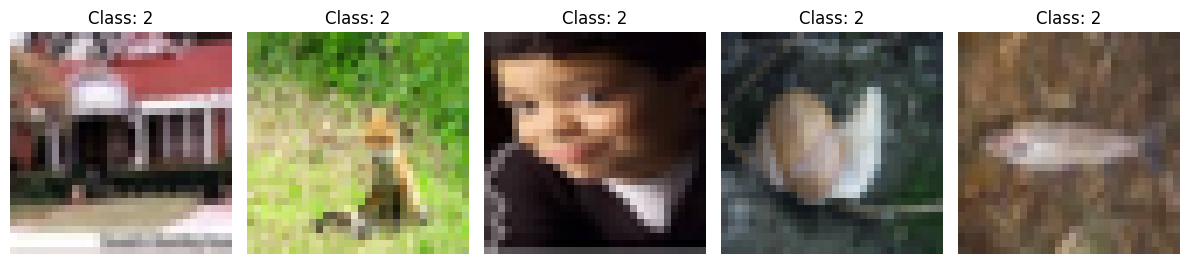

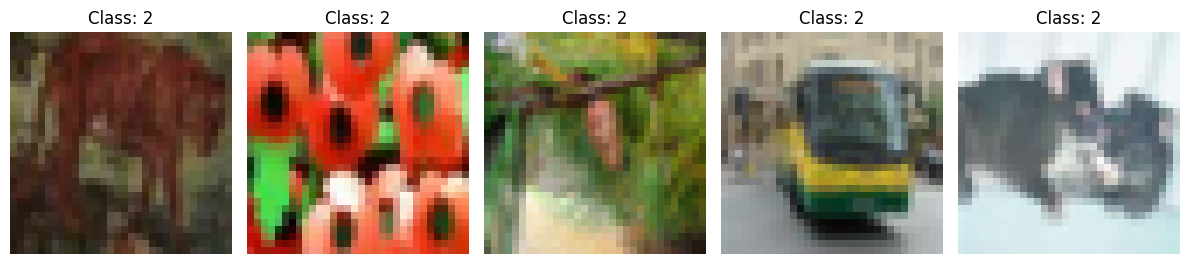

In [95]:
def show_images(images, labels, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i in range(num_images):
        img, label = images[i], labels[i]
        img = img.numpy()
        img = np.transpose(img, (1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

train_images, train_labels = zip(*sub_data_train)
test_images, test_labels = zip(*sub_data_test)

show_images(train_images, train_labels, num_images=5)
show_images(test_images, test_labels, num_images=5)


# Обучение

In [80]:
number_classes = 3
batch_size = 64
epochs = 15

In [27]:
def train(model, train_loader, device, epochs):
  total_loss = []
  for epoch in range(epochs):
    model.train()  # Установка модели в режим обучения
    running_loss = 0
    for i, (inputs, labels) in enumerate(train_loader, 0):

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {running_loss}")
    total_loss.append(running_loss)

  return total_loss


def predict(model,test_loader, device):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs.float())
          _, predicted = torch.max(outputs.data, 1)
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  return all_preds, all_labels


In [28]:
# Определение данных и модели
model_original = torchvision.models.resnet18(pretrained=True) # предобученная модель ResNet18 из "коробки".

train_loader = DataLoader(sub_data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(sub_data_test, batch_size=batch_size, shuffle=False)

In [29]:
# Перенос модели на GPU, если доступен
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_original = model_original.to(device)

# Определяем критерий (функция потерь) и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_original.parameters(), lr=0.001, momentum=0.9)

# Обучение модели
total_loss = train(model_original, train_loader, device, epochs)

Epoch [1/15] - Loss: 114.03721141815186
Epoch [2/15] - Loss: 19.726927518844604
Epoch [3/15] - Loss: 11.421731606125832
Epoch [4/15] - Loss: 7.358260124921799
Epoch [5/15] - Loss: 4.740956284105778
Epoch [6/15] - Loss: 3.566608004271984
Epoch [7/15] - Loss: 3.0945605598390102
Epoch [8/15] - Loss: 1.2656249646097422
Epoch [9/15] - Loss: 0.9799060607329011
Epoch [10/15] - Loss: 1.0547194364480674
Epoch [11/15] - Loss: 0.8508221697993577
Epoch [12/15] - Loss: 0.8757526384433731
Epoch [13/15] - Loss: 0.4601596549618989
Epoch [14/15] - Loss: 0.4846112309023738
Epoch [15/15] - Loss: 0.3878720053471625


In [49]:
all_preds_original, all_labels_original = predict(model_original, test_loader, device)

# Анализ результатов

### Анализ поведения ошибки при обучении модели

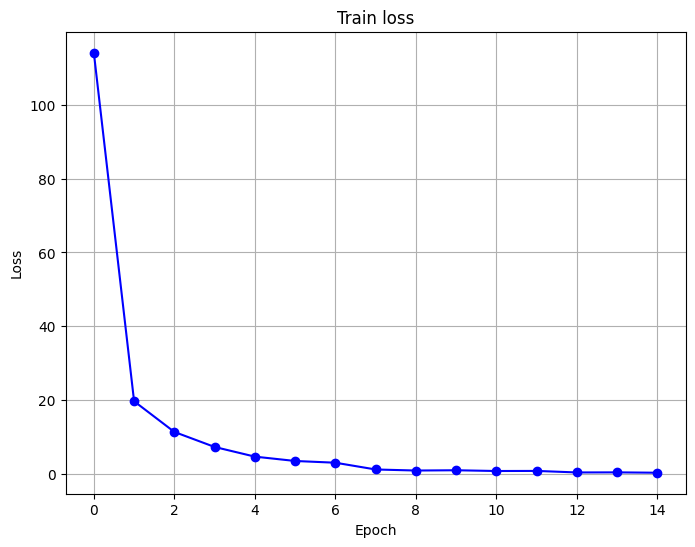

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(total_loss, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train loss')
plt.grid(True)
plt.show()

<b>Комментарий:</b>

Значение ошибки уменьшается на каждой последующей эпохе обучения, это указывает на то, что модель обучается.

### Confusion matrix

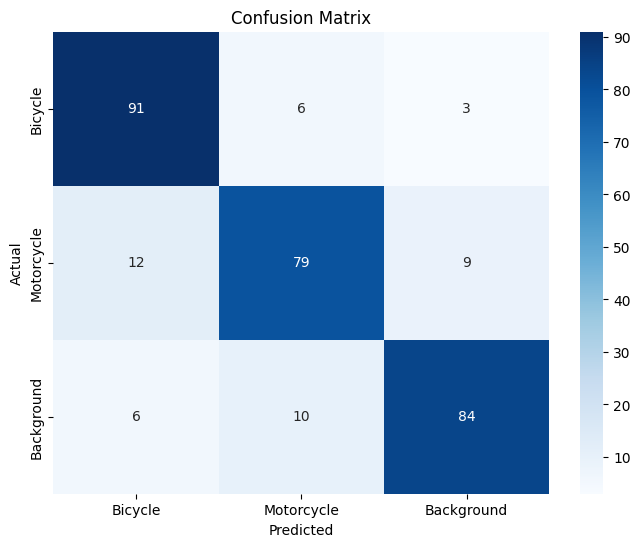

In [70]:
# Создание confusion matrix
conf_matrix = confusion_matrix(all_labels_original, all_preds_original)

# Визуализация confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bicycle', 'Motorcycle', 'Background'], yticklabels=['Bicycle', 'Motorcycle', 'Background'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<b>Комментарий:</b>

Отметим важные моменты:

* Класс bicycle чаще всего путался с motorcycle. Что объяснимо, так как два вида транспортных средст достаточно похожи друг на друга.
* Класс motorcycle и background чаще всего путались друг с другом.

Можно сделать вывод, что модель лучше опеделяет класс motorcycle, чем bicycle.

### Подход Transfer Learning

Предлагается использовать предварительно обученную модель и произвести процедуру "transfer learning", заморозив веса предыдущих слоев и переопределив финальный слой для обучения на конкретной задаче.

In [52]:
def get_tl_resnet_model_(number_classes):
  # Загрузка предварительно обученной модели ResNet-18
  model = torchvision.models.resnet18(pretrained=True)

  # Замораживаем параметры предварительно обученной модели
  for param in model.parameters():
      param.requires_grad = False

  # Переопределяем последний полносвязный слой для CIFAR-100 (3 классов)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, number_classes)
  return model

In [53]:
model_tl = get_tl_resnet_model_(number_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
# Перенос модели на GPU, если доступен
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_tr = model_tl.to(device)

# Определяем критерий (функция потерь) и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_tr.parameters(), lr=0.001, momentum=0.9)

# Обучение модели
total_loss_ = train(model_tr, train_loader, device, epochs)

Epoch [1/15] - Loss: 27.35682338476181
Epoch [2/15] - Loss: 20.63702082633972
Epoch [3/15] - Loss: 18.59878408908844
Epoch [4/15] - Loss: 17.558064877986908
Epoch [5/15] - Loss: 17.42884784936905
Epoch [6/15] - Loss: 17.40098738670349
Epoch [7/15] - Loss: 16.640377044677734
Epoch [8/15] - Loss: 16.013157725334167
Epoch [9/15] - Loss: 16.22005307674408
Epoch [10/15] - Loss: 15.500184714794159
Epoch [11/15] - Loss: 15.501867592334747
Epoch [12/15] - Loss: 14.957329899072647
Epoch [13/15] - Loss: 14.960824489593506
Epoch [14/15] - Loss: 15.363349080085754
Epoch [15/15] - Loss: 15.736032903194427


In [56]:
all_preds_tl, all_labels_tl = predict(model_tl, test_loader, device)

# Сравнение результатов

In [83]:
RESULT_METRICS = {}

In [84]:
def get_metrics(true_labels, predicted_labels, num_classes):

  accuracy = accuracy_score(true_labels, predicted_labels)
  precision = precision_score(true_labels, predicted_labels, average='weighted')
  recall = recall_score(true_labels, predicted_labels, average='weighted')
  f1score = f1_score(true_labels, predicted_labels, average='weighted')

  return round(accuracy,3), round(precision,3), round(recall,3), round(f1score,3)


In [85]:
accuracy_original, precision_original, recall_original, f1score_original  = get_metrics(all_labels_original, all_preds_original, number_classes)
accuracy_tl, precision_tl, recall_tl, f1score_tl  = get_metrics(all_labels_tl, all_preds_tl, number_classes)

In [86]:
RESULT_METRICS['RESNET_ORIGINAL'] = [accuracy_original, precision_original, recall_original, f1score_original]
RESULT_METRICS['RESNET_TL'] = [accuracy_tl, precision_tl, recall_tl, f1score_tl ]

In [87]:
pd.DataFrame.from_dict(RESULT_METRICS, orient = 'index', columns = ['Accuracy', 'Precision', 'Recall', 'F1'])

,Accuracy,Precision,Recall,F1
RESNET_ORIGINAL,0.847,0.847,0.847,0.846
RESNET_TL,0.673,0.677,0.673,0.672


<b>Комментарий:</b>

Модель RESNET_TL, обученная с применением Transfer Learning, показывает заметно худшие результаты по сравнению с исходной моделью RESNET_ORIGINAL по всем метрикам (Accuracy, Precision, Recall, F1-score).

Это указывает на то, что использование Transfer Learning в данном случае не было эффективным.

# Сравнение производительности в разных рантаймах

In [65]:
# !pip install onnxruntime
# !pip install onnx
# !pip install openvino
# !pip install --upgrade openvino-dev

In [69]:
import onnxruntime
import onnx
import openvino as ov
from openvino.tools import mo
import tensorflow as tf
import torchvision.models as models

In [71]:
input = dataset_test[0][0]
input = input.float().unsqueeze(0)

COMPARE_TIMES = {}
epochs_ = 100

In [72]:
# Чисто на cpu
device = "cpu"
model_original.to(device)
input = input.to(device)

time_start = time.perf_counter()
for epoch in range(epochs_):
  with torch.no_grad():
    model_original(input)

COMPARE_TIMES["PyTorch_CPU"] = (time.perf_counter() - time_start) / epochs

In [73]:
# На GPU
device = torch.device("cuda")
model_original.to(device)
input = input.to(device)

time_start = time.perf_counter()
for epoch in range(epochs_):
  with torch.no_grad():
    model_original(input)

COMPARE_TIMES["PyTorch_GPU"] = (time.perf_counter() - time_start) / epochs

In [74]:
# ONNX
device = 'cpu'
model_original.to(device)
input = input.to(device)

torch.onnx.export(model_original, input, "model.onnx", verbose=True)
ort_session = onnxruntime.InferenceSession("model.onnx")
time_start = time.perf_counter()
for epoch in range(epochs_):
  with torch.no_grad():
    ort_session.run(None, {"input.1": np.array(input)})

COMPARE_TIMES["ONNX"] = (time.perf_counter() - time_start) / epochs

In [75]:
# OpenVINO
core = ov.Core()
model_original.to("cpu")
model_ov = ov.tools.mo.convert_model(model_original, example_input=input)
model_ov = core.compile_model(model=model_ov, device_name="CPU")
input_layer = model_ov.input(0)
output_layer = model_ov.output(0)

time_start = time.perf_counter()
for epoch in range(epochs_):
    with torch.no_grad():
        model_ov(input)[output_layer]
COMPARE_TIMES["OpenVINO"] = (time.perf_counter() - time_start) / epochs

In [76]:
pd.DataFrame.from_dict(COMPARE_TIMES, orient = 'index', columns = ['Time'])

,Time
PyTorch_CPU,0.008546
PyTorch_GPU,0.006372
ONNX,0.001787
OpenVINO,0.012295


<b>Комментарий:</b>

На основе таблицы можно сделать несколько выводов:

* <b>PyTorch_CPU vs. PyTorch_GPU</b>: Разница во времени выполнения между CPU и GPU подчеркивает выигрыш в производительности при использовании GPU для обработки модели.

* <b>ONNX:</b> Время выполнения ONNX модели существенно меньше по сравнению с PyTorch. ONNX предоставляет оптимизированные варианты моделей, которые могут работать быстрее и эффективнее благодаря использованию различных инструментов для оптимизации и исполнения моделей.

* <b>OpenVINO:</b> Время выполнения OpenVINO несколько больше, чем у других фреймворков, что может быть вызвано различными факторами, включая процесс оптимизации моделей для аппаратных средств с использованием специальных оптимизаций Intel. Это также может зависеть от специфики модели и устройства, на котором запускается OpenVINO.

# Mанипуляция весами

## GrayScale

In [77]:
class ToGrayscale(object):
    def __call__(self, img):
        return transforms.functional.rgb_to_grayscale(img)
transform_gray = transforms.Compose([
    ToGrayscale(),
    transforms.ToTensor()
])

train_loader.dataset.transform = transform_gray
test_loader.dataset.transform = transform_gray

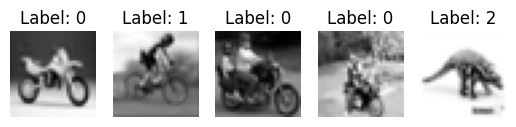

In [92]:
num_images_to_show = 5
for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.float()  # Изменяем тип данных на float
    for idx in range(num_images_to_show):
        plt.subplot(1, num_images_to_show, idx + 1)
        plt.imshow(images[idx][0], cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()
    break  # Показываем только первый батч изображений

In [82]:
# Перенос модели на GPU, если доступен
model_gs = torchvision.models.resnet18(pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rg = model_gs.to(device)

# Определяем критерий (функция потерь) и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_gs.parameters(), lr=0.001, momentum=0.9)

# Обучение модели
_ = train(model_gs, train_loader, device, epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15] - Loss: 115.93636226654053
Epoch [2/15] - Loss: 15.889746993780136
Epoch [3/15] - Loss: 10.92545922100544
Epoch [4/15] - Loss: 7.319937884807587
Epoch [5/15] - Loss: 4.809242591261864
Epoch [6/15] - Loss: 3.8810335025191307
Epoch [7/15] - Loss: 2.4513697288930416
Epoch [8/15] - Loss: 1.4091628082096577
Epoch [9/15] - Loss: 1.4724569879472256
Epoch [10/15] - Loss: 0.9674720079638064
Epoch [11/15] - Loss: 0.7283798607531935
Epoch [12/15] - Loss: 0.48978758323937654
Epoch [13/15] - Loss: 0.49418297153897583
Epoch [14/15] - Loss: 0.4984621265903115
Epoch [15/15] - Loss: 0.6056517597753555


In [90]:
all_preds_gs, all_labels_gs = predict(model_gs, test_loader, device)

In [91]:
accuracy_gs, precision_gs, recall_gs, f1score_gs  = get_metrics(all_labels_gs, all_preds_gs, number_classes)

RESULT_METRICS['RESNET_GS'] = [accuracy_gs, precision_gs, recall_gs, f1score_gs ]

pd.DataFrame.from_dict(RESULT_METRICS, orient = 'index', columns = ['Accuracy', 'Precision', 'Recall', 'F1'])

,Accuracy,Precision,Recall,F1
RESNET_ORIGINAL,0.847,0.847,0.847,0.846
RESNET_TL,0.673,0.677,0.673,0.672
RESNET_GS,0.820,0.823,0.820,0.821


<b>Комментарий:</b>

Заметим, что модель RESNET_GS, работающая с изображениями в оттенках серого (grayscale), имеет немного сниженные показатели точности (accuracy, precision, recall и F1) по сравнению с оригинальной RESNET моделью.

Использование изображений в оттенках серого может снизить информативность модели, поскольку цвет является важным аспектом для распознавания объектов на изображениях. В результате снижения цветовой информации некоторые ключевые аспекты объектов могут теряться, что приводит к снижению общих метрик оценки модели, таких как accuracy, precision, recall и F1.